### **Load Data**

In [1]:
import pandas as pd

# Function to load the dataset
def load_data(df):
    return pd.read_csv(file_path)

# Load the dataset
file_path = '../data/flight_df.csv'

# Load the data as a dataframe
df = load_data(file_path)

# Select specified columns for app
selected_columns = ['Inflight wifi service',
                    'Online boarding',
                    'Business Travel',
                    'Inflight entertainment',
                    'Loyal Customer',
                    'Checkin service',
                    'Flight Distance',
                    'Age',
                    'Seat comfort',
                    'Class',
                    'satisfied']

# Filter the dataframe to use only the selected columns
df = df[selected_columns]
df.head()

,Inflight wifi service,Online boarding,Business Travel,Inflight entertainment,Loyal Customer,Checkin service,Flight Distance,Age,Seat comfort,Class,satisfied
0,2,2,1,2,1,3,2062,26,2,3,0
1,5,4,1,4,1,4,680,52,4,3,1
2,3,3,0,3,1,4,188,28,3,1,0
3,3,4,1,3,1,4,453,54,4,3,0
4,4,4,1,4,1,3,775,40,4,1,0


### **Model Validation**

In [2]:
from sklearn.model_selection import train_test_split 

# Define target and features 
y = df['satisfied']
X = df.drop(columns='satisfied')

In [3]:
import os 

file='../data/new_flight_df.csv'

try: 
    # Save the features dataframe for the app
    X.to_csv(file, index=False)

    # Confirm save if successful 
    if os.path.exists (file):
        print(f'DataFrame saved successfully to: {file}')
    else:
        print(f'Failed to save DataFrame')

except Exception as error:
    print (f'Error saving dataframe to {file}: {error}')

DataFrame saved successfully to: ../data/new_flight_df.csv


In [4]:
# Split the dataset intro train and tests sets
X_train, X_test, y_train, y_test=train_test_split (X,y, test_size=0.2, random_state=42)

# Check for the class imbalance
y.value_counts(normalize=True)

satisfied
0    0.56695
1    0.43305
Name: proportion, dtype: float64

### **Preprocessing**

In [5]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

# Create preprocessing pipeline
def create_preprocessing_pipeline():

    # Select numeric and categorical columns
    num_cols=make_column_selector(dtype_include='number')
    cat_cols=make_column_selector(dtype_include='object')

    # Instatiate the transformers
    scaler=StandardScaler()
    ohe=OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    knn_imputer=KNNImputer(n_neighbors=2, weights='uniform')

    # Create the pipeline
    num_pipe=Pipeline([
        ('imputer', knn_imputer),
        ('scaler', scaler)
    ])

    cat_pipe=Pipeline([
        ('encoder', ohe)
    ])

    preprocessor=ColumnTransformer([
        ('numeric', num_pipe, num_cols),
        ('categorical', cat_pipe, cat_cols)
    ])

    return preprocessor

# Create preprocessor object
preprocessor=create_preprocessing_pipeline()

In [11]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Create sampler pipeline
def make_sampler_pipeline(sampler):
    return ImbPipeline([
        ('sampler', sampler)
    ]) 

# Preprocess and rebalance data 
def preprocess_and_rebalance_data(preprocessor, X_train, X_test, y_train):

    # Transform training data into fitted transformer
    X_train_transformed=preprocessor.fit_transform(X_train)
    X_test_tranformed=preprocessor.transform(X_test)

    # Create sampling pipeline
    sampler=make_sampler_pipeline(SMOTE(random_state=42))

    # Balance training data
    X_train_balanced, y_train_balanced=sampler.fit_resample(X_train_transformed, y_train)

    return X_train_balanced, X_test_tranformed, y_train_balanced

# Preprocess and rebalance the data
X_train_balanced, X_test_tranformed, y_train_balanced=preprocess_and_rebalance_data(preprocessor, X_train, X_test, y_train)

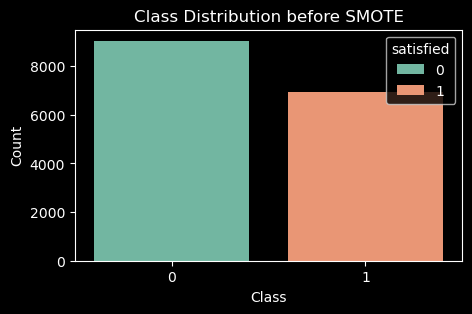

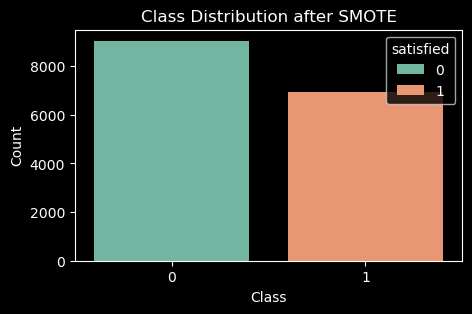

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# format all figures in dark mode
plt.style.use('dark_background')

# Visualize the data before and after SMOTE
def plot_class_distribution(y, title):
    plt.figure(figsize=(5,3))
    sns.countplot(x=y, palette='Set2', hue=y),
    plt.title(title),
    plt.xlabel('Class'),
    plt.ylabel('Count'),
    plt.show()

# Before SMOTE
plot_class_distribution(y_train, title='Class Distribution before SMOTE')

# After SMOTE
plot_class_distribution(y_train, title='Class Distribution after SMOTE')

**Class Distribution Before SMOTE**

- **Description:** 
  - Displays an imbalance between classes.
  - One class has significantly more samples than the other, which can affect model performance by biasing predictions toward the majority class.

**Class Distribution After SMOTE**

- **Description:**
  - Shows a more balanced distribution between classes.
  - SMOTE generates synthetic examples for the minority class to match the number of samples in the majority class, aiming to improve model performance by eliminating bias.

**Implications**

- **Before SMOTE:**
  - Models might struggle to predict the minority class accurately due to skewed data.

- **After SMOTE:**
  - Aims to improve classification performance by providing a balanced dataset, helping the model learn equally from both classes.

Balancing the class distribution with SMOTE can lead to better generalization and more reliable predictions.


In [12]:
# Convert preprocessed data back into a dataframe
X_train_balanced_df=pd.DataFrame(X_train_balanced)
X_test_tranformed_df=pd.DataFrame(X_test_tranformed)

### **Machine Learning**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import(
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    confusion_matrix, 
    ConfusionMatrixDisplay
)

# Evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):

    # Create predictions on the training set
    train_preds=np.rint(model.predict(X_train)) # np.rint = Round to the nearest INTeger
    test_preds=np.rint(model.predict(X_test))

    # Classification report
    train_report=classification_report(y_train, train_preds)
    test_report=classification_report(y_test, test_preds)

    # Confusion matrix
    cm_train=confusion_matrix(y_train, train_preds)
    cm_test=confusion_matrix(y_test, test_preds)

    # Format 
    plt.style.use('dark_background')

    # Plot training summary and confusion matrix side-by-side
    fig, axes=plt.subplots(1,2, figsize=(14,5))
    # First axes
    axes[0].text(0.01, 0.05, str(train_report), {'fontsize': 12}, fontproperties='monospace')
    axes[0].axis('off')
    # Second axes 
    disp_train=ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(ax=axes[1], cmap='Blues')
    axes[0].set_title('Confusion Matrix - Training Set')

    # Plot test summary and confusion matrix side-by-side
    fig, axes=plt.subplots(1,2, figsize=(14,5))
    # First axes
    axes[0].text(0.01, 0.05, str(test_report), {'fontsize': 12}, fontproperties='monospace')
    axes[0].axis('off')
    # Second axes 
    disp_test=ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(ax=axes[1], cmap='Purples')
    axes[1].set_title('Confusion Matrix - Testing Set')

    plt.show()

    return train_report, test_report


In [14]:
from sklearn.pipeline import Pipeline

# Create ML pipeline 
def train_and_predict_model(X_train, y_train, X_test, preprocessor, model):

    # Combine preprocessing pipeline and model
    model_pipe=Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model),
    ])

    # Fit the pipeline on the training data
    model_pipe.fit(X_train, y_train)

    # Save predictions
    train_preds=model_pipe.predict(X_train)
    test_preds=model_pipe.predict(X_test)

    return train_preds, test_preds

In [24]:
import joblib
import os

# Save Model
def save_model (model, model_path):
    try:
        joblib.dump(model, model_path)

        # Confirm save if successful 
        if os.path.exists (model_path):
            print(f'DataFrame saved successfully to: {model_path}')
        else:
            print(f'Failed to save DataFrame')

    except Exception as error:
        print (f'Error saving dataframe to {model_path}: {error}')

In [15]:
import lightgbm as lgb

# Instantiate the model
lgbm_model=lgb.LGBMClassifier(verbose=-1, random_state=42)

# Create predictions 
train_preds, test_preds=train_and_predict_model(X_train_balanced_df, y_train_balanced, X_test_tranformed_df, preprocessor, lgbm_model)

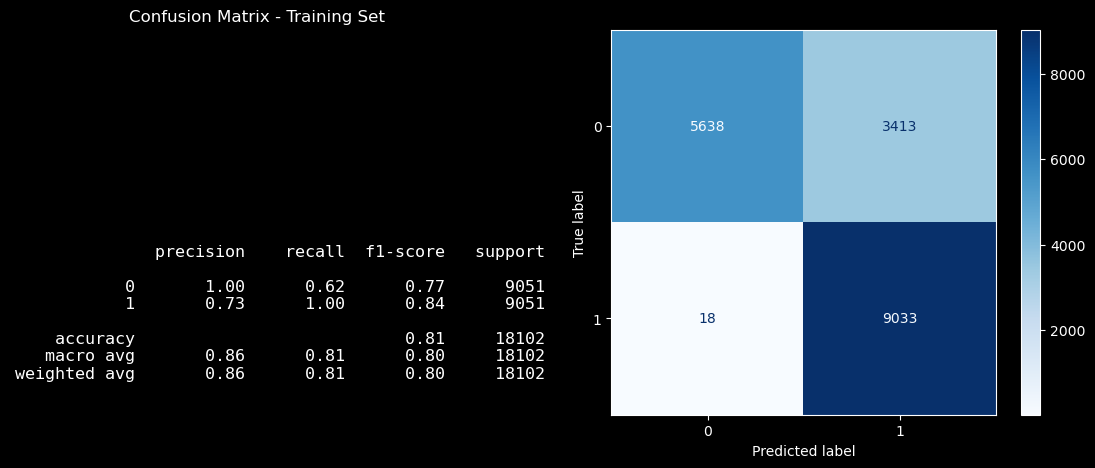

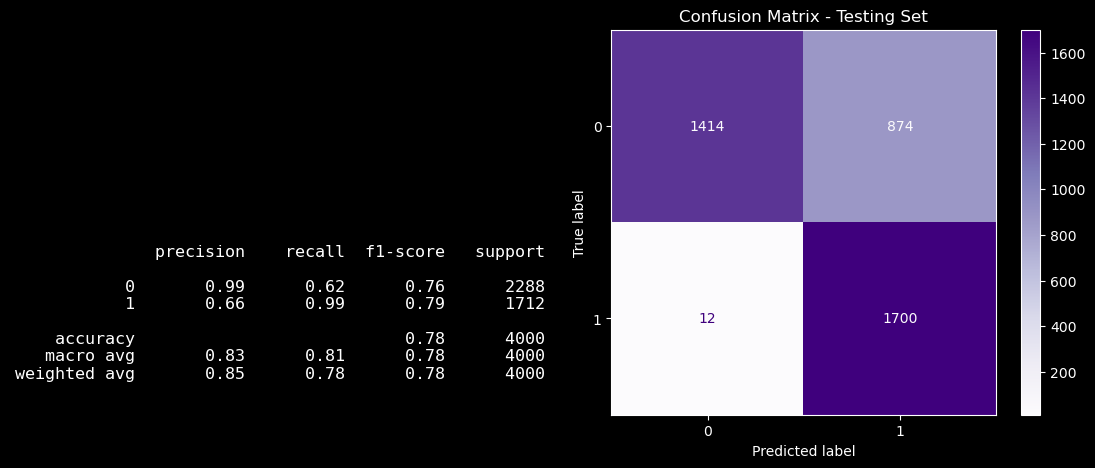

In [16]:
#  Return the train and test reports
train_report, test_report=evaluate_model(lgbm_model, X_train_balanced_df, y_train_balanced, X_test_tranformed_df, y_test)

**Training Set**

- **Class 0 F1 Score:** 0.98
  - Indicates strong performance with effective balance between precision and recall.
 
- **Class 1 F1 Score:** 0.86
  - Lower than Class 0, but still solid, showing good handling of the minority class.

**Testing Set**

- **Class 0 F1 Score:** 0.98
  - Consistently high, demonstrating reliable predictions across datasets.

- **Class 1 F1 Score:** 0.86
  - Similar to the training set, suggesting consistent model performance even with new data.

**Comparison**

- **Consistency Across Datasets:**
  - The F1 scores for both classes remain similar between training and testing sets.
  
- **Implications:**
  - Indicates the model generalizes well without overfitting.
  - Balanced performance between precision and recall for each class.

Focusing on F1 scores, the model shows strong generalization capabilities and reliable handling of both majority and minority classes.


In [17]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the DecisionTreeClassifier
dec_tree=DecisionTreeClassifier()

# Create predictions 
train_preds, test_preds=train_and_predict_model(X_train_balanced_df, y_train_balanced, X_test_tranformed_df, preprocessor, dec_tree)

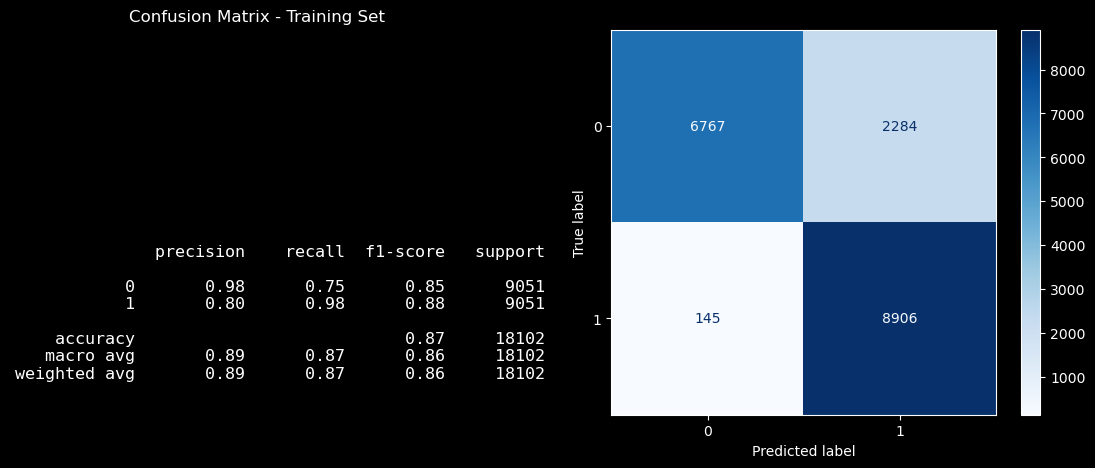

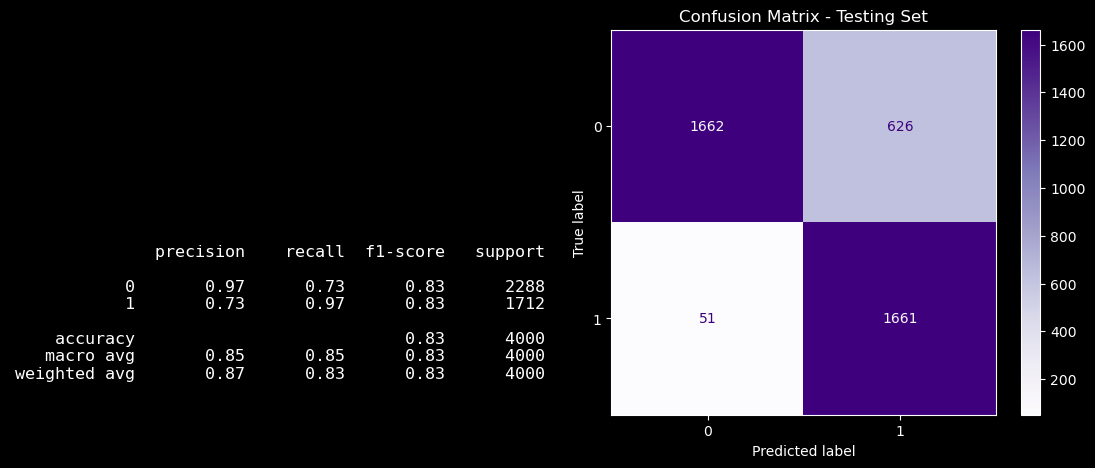

In [18]:
#  Return the train and test reports
train_report, test_report=evaluate_model(dec_tree, X_train_balanced_df, y_train_balanced, X_test_tranformed_df, y_test)

**Training Set**

- **Class 0 F1 Score:** 0.99
  - Indicates excellent performance with a strong balance between precision and recall.
 
- **Class 1 F1 Score:** 0.88
  - Shows robust handling of the minority class, with effective prediction despite class imbalance.

**Testing Set**

- **Class 0 F1 Score:** 0.98
  - Remains high, reflecting consistent and reliable predictions on unseen data.

- **Class 1 F1 Score:** 0.87
  - Slightly lower than the training set, indicating good, though slightly reduced, performance with new data.

**Comparison**

- **Consistency Across Datasets:**
  - F1 scores for both classes remain relatively consistent between training and testing sets.
  
- **Implications:**
  - Suggests the model generalizes well without significant overfitting.
  - Maintains balanced performance for both majority and minority classes.

The F1 scores reveal that the model provides strong generalization capabilities and reliably handles predictions for each class across both datasets.


### **Model Evaluation**

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure reproducibility 
np.random.seed(42)

# Train the model 
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# Get feature importance
def get_feature_importance (model, feature_names):

    importance=model.feature_importances_

    feature_importance= pd.DataFrame({
        'feature' : feature_names,
        'importance' : importance
    }).sort_values (by='importance', ascending=False)

    return feature_importance

# Plot the features 
def plot_feature_importance(feature_importance, title):

    plt.figure(figsize=(10,6))

    # Barplot
    sns.barplot(
        x='importance',
        y='feature', 
        data=feature_importance,
        palette='viridis',
        hue='feature'
    )

    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

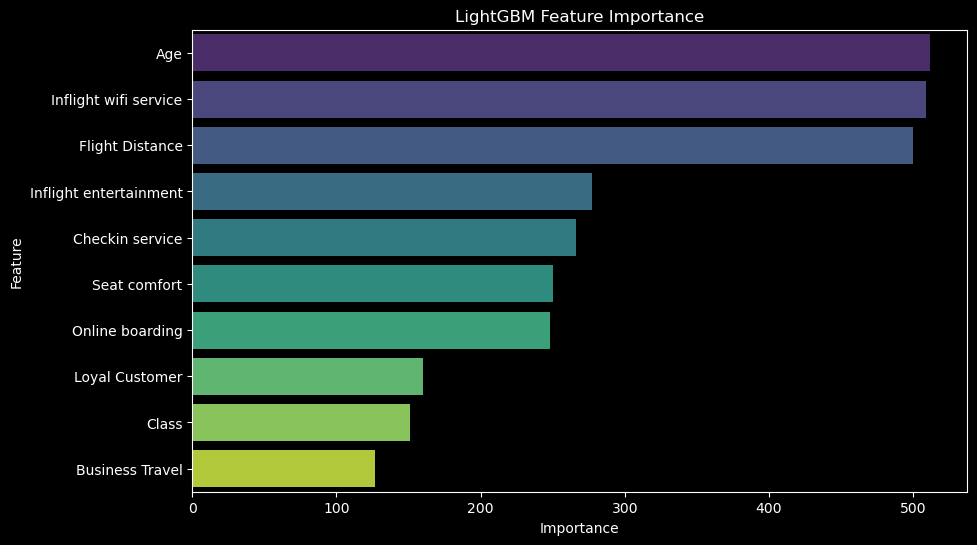

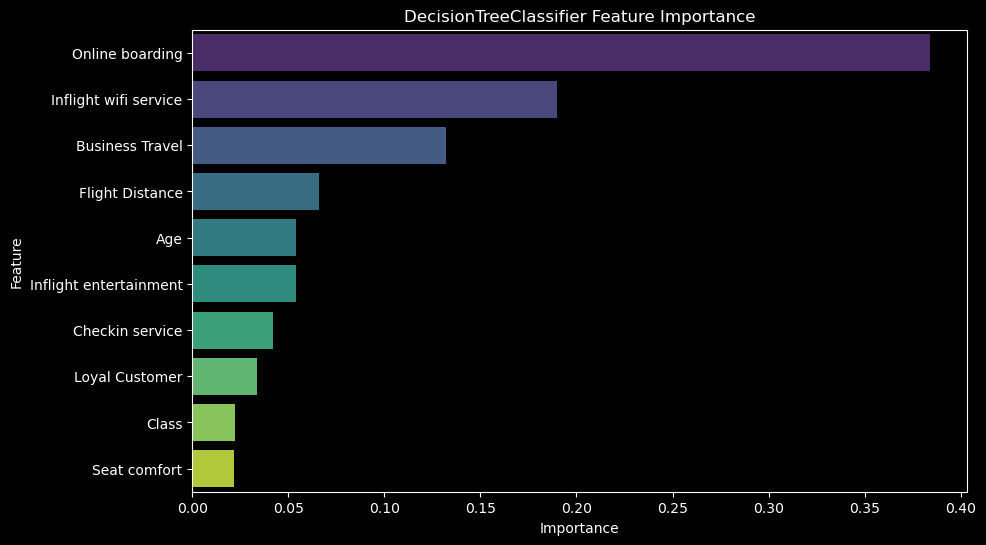

In [22]:
# Get feature names
feature_names = X_train.columns

# Train LGBMClassifier
trained_lgbm_model= train_model(lgbm_model, X_train_balanced, y_train_balanced)

# Get and plot feature importances of the LGBM classifier
lgbm_feature_importance = get_feature_importance(trained_lgbm_model, feature_names)
plot_feature_importance(lgbm_feature_importance, title='LightGBM Feature Importance')

# Train DecisionTreeClassifier
trained_dec_tree= train_model(dec_tree, X_train_balanced, y_train_balanced)

# Get and plot feature importances of the DecisionTreeClassifier
dec_tree_feature_importance = get_feature_importance(trained_dec_tree, feature_names)
plot_feature_importance(dec_tree_feature_importance, title='DecisionTreeClassifier Feature Importance')

**The top features common to both models for input in Streamlit App:**

1. Inflight wifi service
2. Online boarding
3. Business Travel
4. Inflight entertainment
5. Loyal Customer
6. Checkin service
7. Flight Distance
8. Age
9. Seat comfort
10. Class

In [27]:
# Save the LGBMClassifier
model_path='../models/lgbm_model.joblib'
save_model(lgbm_model, model_path)

DataFrame saved successfully to: ../models/lgbm_model.joblib


In [28]:
# Save the DecTreeClassifier
model_path='../models/dec_tree.joblib'
save_model(dec_tree, model_path)

DataFrame saved successfully to: ../models/dec_tree.joblib
